In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json

In [3]:
# from datasets import load_dataset

# # Load SQuAD dataset and select only 5 examples
# squad = load_dataset("squad", split="train[:1]")

# for example in squad:
#     print(f"Context: {example['context']}")
#     print(f"Question: {example['question']}")
#     print(f"Answer: {example['answers']['text'][0]}")
#     print("="*80)
#     break


In [4]:
# from transformers import GPT2Tokenizer

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token

# def format_qa(example):
#     prompt = f"Context: {example['context']}\nQuestion: {example['question']}\nAnswer:"
#     answer = example['answers']['text'][0] + tokenizer.eos_token
#     return {"input_text": prompt, "output_text": answer}

# formatted = squad.map(format_qa)

# def tokenize(example):
#     input_ids = tokenizer(example['input_text'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")["input_ids"][0]
#     labels = tokenizer(example['input_text'] + " " + example['output_text'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")["input_ids"][0]
#     return {"input_ids": input_ids, "labels": labels}

# tokenized_dataset = formatted.map(tokenize)


In [5]:
# from transformers import GPT2LMHeadModel, Trainer, TrainingArguments
# import torch
# from torch.utils.data import Dataset

# class QADataset(Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __getitem__(self, idx):
#         return {
#             "input_ids": self.data[idx]["input_ids"],
#             "attention_mask": self.data[idx]["input_ids"] != tokenizer.pad_token_id,
#             "labels": self.data[idx]["labels"]
#         }

#     def __len__(self):
#         return len(self.data)

# model = GPT2LMHeadModel.from_pretrained("gpt2")
# model.resize_token_embeddings(len(tokenizer))

# qa_dataset = QADataset(tokenized_dataset)

# training_args = TrainingArguments(
#     output_dir="./qa-gpt2",
#     per_device_train_batch_size=8,
#     num_train_epochs=2,
#     logging_steps=1,
#     save_steps=10,
#     save_total_limit=1,
#     report_to="none",
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=qa_dataset,
# )

# trainer.train()


In [6]:
# model.eval()

# def generate_answer(context, question):
#     prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')
#     output = model.generate(input_ids, max_new_tokens=10,  eos_token_id=tokenizer.eos_token_id,pad_token_id=tokenizer.eos_token_id)  # Avoid warning if pad token is undefined)
#     answer = tokenizer.decode(output[0], skip_special_tokens=True)
#     return answer.split("Answer:")[-1].strip()

# # Test on training examples
# for example in squad:
#     print("Q:", example['question'])
#     print("Predicted A:", generate_answer(example['context'], example['question']))
#     print("True A:", example['answers']['text'][0])
#     print("="*60)
#     break


### Custom Model with Separate Key Query and Value

In [7]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Block, GPT2Model, GPT2PreTrainedModel
from transformers.modeling_utils import Conv1D

# --------- Custom Attention Module using Conv1D ----------
class CustomGPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        assert self.head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.q_proj = Conv1D(self.embed_dim, self.embed_dim)
        self.k_proj = Conv1D(self.embed_dim, self.embed_dim)
        self.v_proj = Conv1D(self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.scale = self.head_dim ** -0.5
        
        # Register causal mask buffer (same as original GPT2)
        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            ),
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4))

    def _split_heads(self, x):
        batch_size, seq_len, embed_dim = x.size()
        # embed_dim should equal num_heads * head_dim
        assert embed_dim == self.num_heads * self.head_dim, f"Embed dim {embed_dim} != num_heads * head_dim {self.num_heads * self.head_dim}"
        
        # reshape to (batch_size, seq_len, num_heads, head_dim)
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # permute to (batch_size, num_heads, seq_len, head_dim)
        return x.permute(0, 2, 1, 3)

    def _merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (self.embed_dim,)
        return x.view(*new_shape)

    def forward(self, hidden_states, layer_past=None, attention_mask=None,
                head_mask=None, use_cache=False, output_attentions=False):
    
        # Project to Q, K, V
        query = self.q_proj(hidden_states)
        key = self.k_proj(hidden_states)
        value = self.v_proj(hidden_states)

        # Split heads
        query = self._split_heads(query)
        key = self._split_heads(key)
        value = self._split_heads(value)

        # Handle past keys/values for generation
        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache:
            present = (key, value)
        else:
            present = None

        # Compute attention weights
        attn_weights = torch.matmul(query, key.transpose(-1, -2))
        attn_weights = attn_weights * self.scale

        # Apply causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

        # Apply attention mask if provided
        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        # Softmax
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Apply head mask if provided
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        # Apply attention to values
        attn_output = torch.matmul(attn_weights, value)
        attn_output = self._merge_heads(attn_output)

        # Final projection
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [8]:
# --------- Custom GPT2 Block ----------
class CustomGPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.attn = CustomGPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.mlp = GPT2Block(config).mlp

    def forward(
        self,
        hidden_states,
        layer_past=None,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=False,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)

        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )

        attn_output = attn_outputs[0]
        outputs = attn_outputs[1:]

        hidden_states = residual + attn_output

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        hidden_states = residual + feed_forward_hidden_states

        return (hidden_states,) + outputs

In [9]:
# --------- Custom GPT2 Model ----------
class CustomGPT2Model(GPT2Model):
    def __init__(self, config):
        super().__init__(config)
        self.h = nn.ModuleList([CustomGPT2Block(config) for _ in range(config.num_hidden_layers)])

In [10]:
class CustomGPT2LMHeadModel(GPT2LMHeadModel):
    def __init__(self, config):
        # Initialize the parent class first
        super(GPT2PreTrainedModel, self).__init__(config)
        
        # Replace the transformer with our custom one
        self.transformer = CustomGPT2Model(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        
        # Initialize weights
        self.post_init()

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Forward through transformer (excluding labels)
        transformer_outputs = self.transformer(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        hidden_states = transformer_outputs[0]
        lm_logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
        )

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def prepare_inputs_for_generation(self, input_ids, past_key_values=None, inputs_embeds=None, **kwargs):
        token_type_ids = kwargs.get("token_type_ids", None)
        # only last token for inputs_ids if past is defined in kwargs
        if past_key_values:
            past_length = past_key_values[0][0].shape[2]

            # Some generation methods already pass only the last input ID
            if input_ids.shape[1] > past_length:
                remove_prefix_length = past_length
            else:
                # Default to old behavior: keep only final ID
                remove_prefix_length = input_ids.shape[1] - 1

            input_ids = input_ids[:, remove_prefix_length:]
            if token_type_ids is not None:
                token_type_ids = token_type_ids[:, -input_ids.shape[1] :]

        attention_mask = kwargs.get("attention_mask", None)
        position_ids = kwargs.get("position_ids", None)

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -input_ids.shape[1] :]
        else:
            position_ids = None

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and past_key_values is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}

        model_inputs.update(
            {
                "past_key_values": past_key_values,
                "use_cache": kwargs.get("use_cache"),
                "position_ids": position_ids,
                "attention_mask": attention_mask,
                "token_type_ids": token_type_ids,
            }
        )

        return model_inputs

    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past

In [11]:
# --------- Copy Weights from Original GPT2 Model ----------
def copy_weights(original_model, custom_model):
    orig_state_dict = original_model.state_dict()
    custom_state_dict = custom_model.state_dict()

    for name, param in orig_state_dict.items():
        if "attn.c_attn.weight" in name:
            layer_num = int(name.split('.')[2])
            prefix = f'transformer.h.{layer_num}.attn.'
            
            # Original c_attn weight shape: (embed_dim, 3 * embed_dim)
            # Need to split along dim=1 (the 3 * embed_dim dimension)
            embed_dim = param.shape[0]
            q_weight, k_weight, v_weight = torch.split(param, embed_dim, dim=1)
            
            # Conv1D weight shape is (input_dim, output_dim), no transpose needed
            custom_state_dict[f'{prefix}q_proj.weight'].copy_(q_weight)
            custom_state_dict[f'{prefix}k_proj.weight'].copy_(k_weight)  
            custom_state_dict[f'{prefix}v_proj.weight'].copy_(v_weight)

        elif "attn.c_attn.bias" in name:
            layer_num = int(name.split('.')[2])
            prefix = f'transformer.h.{layer_num}.attn.'
            hidden_size = param.shape[0] // 3

            q_bias, k_bias, v_bias = torch.split(param, hidden_size)
            custom_state_dict[f'{prefix}q_proj.bias'].copy_(q_bias)
            custom_state_dict[f'{prefix}k_proj.bias'].copy_(k_bias)
            custom_state_dict[f'{prefix}v_proj.bias'].copy_(v_bias)

        elif "attn.c_proj.weight" in name:
            # Copy c_proj weights directly
            layer_num = int(name.split('.')[2])
            prefix = f'transformer.h.{layer_num}.attn.'
            custom_state_dict[f'{prefix}c_proj.weight'].copy_(param)
            
        else:
            if name in custom_state_dict:
                custom_state_dict[name].copy_(param)

    custom_model.load_state_dict(custom_state_dict)

In [12]:
# config = GPT2Config.from_pretrained("gpt2")
# original_model = GPT2LMHeadModel.from_pretrained("gpt2")
# custom_model = CustomGPT2LMHeadModel(config)
# copy_weights(original_model, custom_model)


In [13]:
(5e-5)*8

0.0004

In [14]:
# 4 times

In [15]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, get_scheduler
from transformers import GPT2TokenizerFast


from torch.optim import AdamW,SGD
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -------------------------------
# Load and prepare SQuAD dataset
# -------------------------------
squad = load_dataset("squad", split="train[:20000]")  # Small subset for testing

#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Initialize the fast tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to EOS

def format_qa(example):
    prompt = f"Context: {example['context']}\nQuestion: {example['question']}\nAnswer:"
    answer = example['answers']['text'][0] + tokenizer.eos_token
    return {"input_text": prompt, "output_text": answer}

formatted = squad.map(format_qa)

def tokenize(example):
    input_enc = tokenizer(example['input_text'], truncation=True, padding="max_length", max_length=512)
    output_enc = tokenizer(example['input_text'] + " " + example['output_text'], truncation=True, padding="max_length", max_length=512)
    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": output_enc["input_ids"]
    }

tokenized = formatted.map(tokenize)

# -------------------------------
# PyTorch Dataset
# -------------------------------
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.data[idx]["input_ids"]),
            "attention_mask": torch.tensor(self.data[idx]["attention_mask"]),
            "labels": torch.tensor(self.data[idx]["labels"]),
        }

    def __len__(self):
        return len(self.data)

qa_dataset = QADataset(tokenized)

# DataLoader with default collate_fn
dataloader = DataLoader(qa_dataset, batch_size=8, shuffle=True)

# -------------------------------
# Model and Optimizer Setup
# -------------------------------
#model = GPT2LMHeadModel.from_pretrained("gpt2")

config = GPT2Config.from_pretrained("gpt2")
original_model = GPT2LMHeadModel.from_pretrained("gpt2")
model = CustomGPT2LMHeadModel(config)
copy_weights(original_model, model)
model.resize_token_embeddings(len(tokenizer))

#optimizer = AdamW(model.parameters(), lr=5e-5)


optimizer = AdamW(
    [
        {"params": [p for n, p in model.named_parameters() if 'attn.q_proj' in n or 'attn.k_proj' in n], "lr": 4e-4},
        {"params": [p for n, p in model.named_parameters() if 'attn.q_proj' not in n and 'attn.k_proj' not in n], "lr": 5e-5}
    ],
    weight_decay=0.01,
    eps=1e-8
)





epochs = 25
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Scheduler
num_training_steps = len(dataloader) * epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# -------------------------------
# Training Loop with Logging
# -------------------------------
logging_steps = 200
global_step = 0

model.train()
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    loop = tqdm(dataloader, desc="Training", leave=False)
    
    for step, batch in enumerate(loop):
        global_step += 1
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())

        if global_step % logging_steps == 0:
            print(f"Step {global_step} - Loss: {loss.item():.4f}")


Epoch 1/25


Training:   8%|█▍                | 200/2500 [01:17<14:52,  2.58it/s, loss=0.869]

Step 200 - Loss: 0.8688


Training:  16%|██▉               | 400/2500 [02:35<13:33,  2.58it/s, loss=0.907]

Step 400 - Loss: 0.9071


Training:  24%|████▎             | 600/2500 [03:53<12:16,  2.58it/s, loss=0.855]

Step 600 - Loss: 0.8553


Training:  32%|█████▊            | 800/2500 [05:10<11:00,  2.57it/s, loss=0.967]

Step 800 - Loss: 0.9667


Training:  40%|██████▊          | 1000/2500 [06:28<09:43,  2.57it/s, loss=0.889]

Step 1000 - Loss: 0.8894


Training:  48%|████████▏        | 1200/2500 [07:46<08:27,  2.56it/s, loss=0.854]

Step 1200 - Loss: 0.8538


Training:  56%|██████████        | 1400/2500 [09:04<07:08,  2.57it/s, loss=0.74]

Step 1400 - Loss: 0.7401


Training:  64%|██████████▉      | 1600/2500 [10:22<05:51,  2.56it/s, loss=0.614]

Step 1600 - Loss: 0.6140


Training:  72%|████████████▏    | 1800/2500 [11:40<04:32,  2.57it/s, loss=0.695]

Step 1800 - Loss: 0.6954


Training:  80%|█████████████▌   | 2000/2500 [12:58<03:15,  2.56it/s, loss=0.664]

Step 2000 - Loss: 0.6640


Training:  88%|██████████████▉  | 2200/2500 [14:16<01:57,  2.55it/s, loss=0.669]

Step 2200 - Loss: 0.6685


Training:  96%|████████████████▎| 2400/2500 [15:35<00:39,  2.55it/s, loss=0.868]

Step 2400 - Loss: 0.8684



Epoch 2/25


Training:   4%|▋                 | 100/2500 [00:39<15:37,  2.56it/s, loss=0.607]

Step 2600 - Loss: 0.6067


Training:  12%|██▏               | 300/2500 [01:57<14:27,  2.54it/s, loss=0.774]

Step 2800 - Loss: 0.7736


Training:  20%|███▌              | 500/2500 [03:16<13:07,  2.54it/s, loss=0.779]

Step 3000 - Loss: 0.7788


Training:  28%|█████             | 700/2500 [04:35<11:51,  2.53it/s, loss=0.687]

Step 3200 - Loss: 0.6867


Training:  36%|██████▊            | 900/2500 [05:55<10:41,  2.49it/s, loss=0.57]

Step 3400 - Loss: 0.5699


Training:  44%|███████▍         | 1100/2500 [07:17<09:42,  2.40it/s, loss=0.469]

Step 3600 - Loss: 0.4695


Training:  52%|████████▊        | 1300/2500 [08:39<08:10,  2.45it/s, loss=0.523]

Step 3800 - Loss: 0.5232


Training:  60%|██████████▏      | 1500/2500 [10:03<07:16,  2.29it/s, loss=0.498]

Step 4000 - Loss: 0.4983


Training:  68%|████████████▏     | 1700/2500 [11:27<05:34,  2.39it/s, loss=0.74]

Step 4200 - Loss: 0.7405


Training:  76%|████████████▉    | 1900/2500 [12:49<04:06,  2.43it/s, loss=0.515]

Step 4400 - Loss: 0.5154


Training:  84%|██████████████▎  | 2100/2500 [14:12<02:42,  2.46it/s, loss=0.614]

Step 4600 - Loss: 0.6145


Training:  92%|███████████████▋ | 2300/2500 [15:35<01:22,  2.43it/s, loss=0.568]

Step 4800 - Loss: 0.5681


Step 5000 - Loss: 0.6705

Epoch 3/25


Training:   8%|█▍                | 200/2500 [01:23<16:02,  2.39it/s, loss=0.506]

Step 5200 - Loss: 0.5061


Training:  16%|██▉               | 400/2500 [02:47<14:33,  2.40it/s, loss=0.467]

Step 5400 - Loss: 0.4675


Training:  24%|████▎             | 600/2500 [04:11<13:09,  2.41it/s, loss=0.459]

Step 5600 - Loss: 0.4587


Training:  32%|█████▊            | 800/2500 [05:35<11:48,  2.40it/s, loss=0.469]

Step 5800 - Loss: 0.4686


Training:  40%|██████▊          | 1000/2500 [06:59<10:24,  2.40it/s, loss=0.342]

Step 6000 - Loss: 0.3420


Training:  48%|████████▏        | 1200/2500 [08:23<09:21,  2.32it/s, loss=0.396]

Step 6200 - Loss: 0.3957


Training:  56%|██████████        | 1400/2500 [09:46<07:37,  2.40it/s, loss=0.42]

Step 6400 - Loss: 0.4199


Training:  64%|██████████▉      | 1600/2500 [11:09<06:13,  2.41it/s, loss=0.414]

Step 6600 - Loss: 0.4144


Training:  72%|████████████▏    | 1800/2500 [12:33<04:51,  2.41it/s, loss=0.475]

Step 6800 - Loss: 0.4754


Training:  80%|██████████████▍   | 2000/2500 [13:57<03:37,  2.30it/s, loss=0.26]

Step 7000 - Loss: 0.2597


Training:  88%|██████████████▉  | 2200/2500 [15:20<02:04,  2.40it/s, loss=0.322]

Step 7200 - Loss: 0.3218


Training:  96%|████████████████▎| 2400/2500 [16:44<00:41,  2.39it/s, loss=0.564]

Step 7400 - Loss: 0.5644



Epoch 4/25


Training:   4%|▋                 | 100/2500 [00:42<16:38,  2.40it/s, loss=0.288]

Step 7600 - Loss: 0.2884


Training:  12%|██▏               | 300/2500 [02:05<15:15,  2.40it/s, loss=0.253]

Step 7800 - Loss: 0.2535


Training:  20%|███▌              | 500/2500 [03:29<14:29,  2.30it/s, loss=0.439]

Step 8000 - Loss: 0.4385


Training:  28%|█████             | 700/2500 [04:53<12:28,  2.40it/s, loss=0.364]

Step 8200 - Loss: 0.3643


Training:  36%|██████▍           | 900/2500 [06:17<11:06,  2.40it/s, loss=0.285]

Step 8400 - Loss: 0.2850


Training:  44%|███████▍         | 1100/2500 [07:40<09:42,  2.40it/s, loss=0.279]

Step 8600 - Loss: 0.2787


Training:  52%|████████▊        | 1300/2500 [09:03<08:03,  2.48it/s, loss=0.323]

Step 8800 - Loss: 0.3228


Training:  60%|██████████▏      | 1500/2500 [10:26<06:58,  2.39it/s, loss=0.376]

Step 9000 - Loss: 0.3757


Training:  68%|███████████▌     | 1700/2500 [11:49<05:32,  2.41it/s, loss=0.286]

Step 9200 - Loss: 0.2863


Training:  76%|████████████▉    | 1900/2500 [13:12<04:09,  2.41it/s, loss=0.263]

Step 9400 - Loss: 0.2635


Training:  84%|███████████████   | 2100/2500 [14:35<02:46,  2.40it/s, loss=0.26]

Step 9600 - Loss: 0.2599


Training:  92%|███████████████▋ | 2300/2500 [15:58<01:23,  2.41it/s, loss=0.247]

Step 9800 - Loss: 0.2472


Step 10000 - Loss: 0.3761

Epoch 5/25


Training:   8%|█▍                | 200/2500 [01:23<16:35,  2.31it/s, loss=0.284]

Step 10200 - Loss: 0.2839


Training:  16%|██▉               | 400/2500 [02:46<14:33,  2.40it/s, loss=0.241]

Step 10400 - Loss: 0.2413


Training:  24%|████▌              | 600/2500 [04:09<13:09,  2.41it/s, loss=0.27]

Step 10600 - Loss: 0.2697


Training:  32%|█████▊            | 800/2500 [05:32<11:46,  2.41it/s, loss=0.308]

Step 10800 - Loss: 0.3084


Training:  40%|██████▊          | 1000/2500 [06:55<10:22,  2.41it/s, loss=0.309]

Step 11000 - Loss: 0.3095


Training:  48%|████████▏        | 1200/2500 [08:18<09:01,  2.40it/s, loss=0.268]

Step 11200 - Loss: 0.2676


Training:  56%|█████████▌       | 1400/2500 [09:41<07:36,  2.41it/s, loss=0.318]

Step 11400 - Loss: 0.3177


Training:  64%|██████████▉      | 1600/2500 [11:04<06:13,  2.41it/s, loss=0.297]

Step 11600 - Loss: 0.2969


Training:  72%|████████████▏    | 1800/2500 [12:27<04:50,  2.41it/s, loss=0.187]

Step 11800 - Loss: 0.1873


Training:  80%|██████████████▍   | 2000/2500 [13:50<03:28,  2.40it/s, loss=0.26]

Step 12000 - Loss: 0.2603


Training:  88%|██████████████▉  | 2200/2500 [15:13<02:04,  2.41it/s, loss=0.186]

Step 12200 - Loss: 0.1861


Training:  96%|████████████████▎| 2400/2500 [16:37<00:41,  2.40it/s, loss=0.282]

Step 12400 - Loss: 0.2825



Epoch 6/25


Training:   4%|▋                 | 100/2500 [00:41<16:38,  2.40it/s, loss=0.242]

Step 12600 - Loss: 0.2420


Training:  12%|██▏               | 300/2500 [02:04<14:47,  2.48it/s, loss=0.297]

Step 12800 - Loss: 0.2966


Training:  20%|███▊               | 500/2500 [03:27<13:52,  2.40it/s, loss=0.27]

Step 13000 - Loss: 0.2697


Training:  28%|█████▌              | 700/2500 [04:50<12:26,  2.41it/s, loss=0.2]

Step 13200 - Loss: 0.2000


Training:  36%|██████▍           | 900/2500 [06:13<11:04,  2.41it/s, loss=0.267]

Step 13400 - Loss: 0.2673


Training:  44%|███████▍         | 1100/2500 [07:37<09:41,  2.41it/s, loss=0.262]

Step 13600 - Loss: 0.2621


Training:  52%|█████████▎        | 1300/2500 [09:00<08:18,  2.41it/s, loss=0.25]

Step 13800 - Loss: 0.2496


Training:  60%|██████████▏      | 1500/2500 [10:23<06:56,  2.40it/s, loss=0.203]

Step 14000 - Loss: 0.2033


Training:  68%|████████████▏     | 1700/2500 [11:46<05:32,  2.41it/s, loss=0.23]

Step 14200 - Loss: 0.2303


Training:  76%|████████████▉    | 1900/2500 [13:10<04:08,  2.41it/s, loss=0.202]

Step 14400 - Loss: 0.2016


Training:  84%|██████████████▎  | 2100/2500 [14:33<02:46,  2.40it/s, loss=0.196]

Step 14600 - Loss: 0.1956


Training:  92%|████████████████▌ | 2300/2500 [15:56<01:23,  2.41it/s, loss=0.23]

Step 14800 - Loss: 0.2305


Step 15000 - Loss: 0.2110

Epoch 7/25


Training:   8%|█▍                | 200/2500 [01:22<15:55,  2.41it/s, loss=0.156]

Step 15200 - Loss: 0.1556


Training:  16%|██▉               | 400/2500 [02:45<14:32,  2.41it/s, loss=0.115]

Step 15400 - Loss: 0.1151


Training:  24%|████▎             | 600/2500 [04:06<12:30,  2.53it/s, loss=0.224]

Step 15600 - Loss: 0.2237


Training:  32%|█████▊            | 800/2500 [05:25<11:09,  2.54it/s, loss=0.156]

Step 15800 - Loss: 0.1563


Training:  40%|██████▊          | 1000/2500 [06:44<09:53,  2.53it/s, loss=0.189]

Step 16000 - Loss: 0.1891


Training:  48%|████████▏        | 1200/2500 [08:03<08:31,  2.54it/s, loss=0.188]

Step 16200 - Loss: 0.1884


Training:  56%|█████████▌       | 1400/2500 [09:22<07:15,  2.53it/s, loss=0.173]

Step 16400 - Loss: 0.1726


Training:  64%|██████████▉      | 1600/2500 [10:41<05:54,  2.54it/s, loss=0.224]

Step 16600 - Loss: 0.2238


Training:  72%|████████████▏    | 1800/2500 [12:00<04:35,  2.54it/s, loss=0.208]

Step 16800 - Loss: 0.2081


Training:  80%|█████████████▌   | 2000/2500 [13:19<03:17,  2.53it/s, loss=0.126]

Step 17000 - Loss: 0.1259


Training:  88%|██████████████▉  | 2200/2500 [14:37<01:58,  2.54it/s, loss=0.164]

Step 17200 - Loss: 0.1639


Training:  96%|████████████████▎| 2400/2500 [15:56<00:39,  2.50it/s, loss=0.182]

Step 17400 - Loss: 0.1822



Epoch 8/25


Training:   4%|▊                  | 100/2500 [00:39<15:46,  2.54it/s, loss=0.19]

Step 17600 - Loss: 0.1903


Training:  12%|██▏               | 300/2500 [01:58<14:26,  2.54it/s, loss=0.165]

Step 17800 - Loss: 0.1652


Training:  20%|███▌              | 500/2500 [03:17<13:07,  2.54it/s, loss=0.149]

Step 18000 - Loss: 0.1490


Training:  28%|█████             | 700/2500 [04:36<11:48,  2.54it/s, loss=0.146]

Step 18200 - Loss: 0.1462


Training:  36%|██████▍           | 900/2500 [05:55<10:30,  2.54it/s, loss=0.173]

Step 18400 - Loss: 0.1731


Training:  44%|███████▉          | 1100/2500 [07:14<09:13,  2.53it/s, loss=0.14]

Step 18600 - Loss: 0.1399


Training:  52%|████████▎       | 1300/2500 [08:32<07:53,  2.53it/s, loss=0.0911]

Step 18800 - Loss: 0.0911


Training:  60%|██████████▊       | 1500/2500 [09:51<06:34,  2.53it/s, loss=0.14]

Step 19000 - Loss: 0.1404


Training:  68%|███████████▌     | 1700/2500 [11:10<05:15,  2.54it/s, loss=0.182]

Step 19200 - Loss: 0.1817


Training:  76%|████████████▉    | 1900/2500 [12:29<03:56,  2.54it/s, loss=0.137]

Step 19400 - Loss: 0.1367


Training:  84%|██████████████▎  | 2100/2500 [13:48<02:38,  2.53it/s, loss=0.117]

Step 19600 - Loss: 0.1169


Training:  92%|███████████████▋ | 2300/2500 [15:07<01:18,  2.54it/s, loss=0.144]

Step 19800 - Loss: 0.1435


Step 20000 - Loss: 0.1796

Epoch 9/25


Training:   8%|█▍                | 200/2500 [01:18<15:05,  2.54it/s, loss=0.141]

Step 20200 - Loss: 0.1410


Training:  16%|██▉               | 400/2500 [02:37<13:49,  2.53it/s, loss=0.114]

Step 20400 - Loss: 0.1137


Training:  24%|████▎             | 600/2500 [03:56<12:26,  2.54it/s, loss=0.201]

Step 20600 - Loss: 0.2010


Training:  32%|█████▊            | 800/2500 [05:15<11:08,  2.54it/s, loss=0.139]

Step 20800 - Loss: 0.1389


Training:  40%|██████▊          | 1000/2500 [06:34<09:50,  2.54it/s, loss=0.143]

Step 21000 - Loss: 0.1433


Training:  48%|████████▏        | 1200/2500 [07:53<08:32,  2.54it/s, loss=0.176]

Step 21200 - Loss: 0.1761


Training:  56%|█████████▌       | 1400/2500 [09:11<07:12,  2.54it/s, loss=0.114]

Step 21400 - Loss: 0.1144


Training:  64%|██████████▉      | 1600/2500 [10:30<05:53,  2.54it/s, loss=0.113]

Step 21600 - Loss: 0.1128


Training:  72%|████████████▏    | 1800/2500 [11:49<04:39,  2.51it/s, loss=0.128]

Step 21800 - Loss: 0.1283


Training:  80%|█████████████▌   | 2000/2500 [13:08<03:17,  2.53it/s, loss=0.114]

Step 22000 - Loss: 0.1143


Training:  88%|██████████████▉  | 2200/2500 [14:27<01:58,  2.54it/s, loss=0.136]

Step 22200 - Loss: 0.1362


Training:  96%|████████████████▎| 2400/2500 [15:46<00:39,  2.53it/s, loss=0.111]

Step 22400 - Loss: 0.1108



Epoch 10/25


Training:   4%|▋                 | 100/2500 [00:39<15:48,  2.53it/s, loss=0.127]

Step 22600 - Loss: 0.1274


Training:  12%|██▏               | 300/2500 [01:58<14:25,  2.54it/s, loss=0.101]

Step 22800 - Loss: 0.1010


Training:  20%|███▌              | 500/2500 [03:17<13:09,  2.53it/s, loss=0.139]

Step 23000 - Loss: 0.1395


Training:  28%|█████             | 700/2500 [04:36<11:49,  2.54it/s, loss=0.115]

Step 23200 - Loss: 0.1149


Training:  36%|██████▍           | 900/2500 [05:55<10:31,  2.54it/s, loss=0.143]

Step 23400 - Loss: 0.1431


Training:  44%|███████▉          | 1100/2500 [07:14<09:11,  2.54it/s, loss=0.17]

Step 23600 - Loss: 0.1699


Training:  52%|████████▊        | 1300/2500 [08:33<07:53,  2.54it/s, loss=0.118]

Step 23800 - Loss: 0.1183


Training:  60%|██████████▏      | 1500/2500 [09:52<06:33,  2.54it/s, loss=0.104]

Step 24000 - Loss: 0.1038


Training:  68%|███████████▌     | 1700/2500 [11:10<05:14,  2.54it/s, loss=0.125]

Step 24200 - Loss: 0.1248


Training:  76%|█████████████▋    | 1900/2500 [12:29<03:56,  2.54it/s, loss=0.11]

Step 24400 - Loss: 0.1104


Training:  84%|██████████████▎  | 2100/2500 [13:48<02:40,  2.50it/s, loss=0.149]

Step 24600 - Loss: 0.1491


Training:  92%|███████████████▋ | 2300/2500 [15:07<01:19,  2.53it/s, loss=0.155]

Step 24800 - Loss: 0.1547


Step 25000 - Loss: 0.1325

Epoch 11/25


Training:   8%|█▎               | 200/2500 [01:18<15:06,  2.54it/s, loss=0.0871]

Step 25200 - Loss: 0.0871


Training:  16%|██▉               | 400/2500 [02:37<13:47,  2.54it/s, loss=0.119]

Step 25400 - Loss: 0.1186


Training:  24%|████             | 600/2500 [03:56<12:28,  2.54it/s, loss=0.0931]

Step 25600 - Loss: 0.0931


Training:  32%|█████▊            | 800/2500 [05:15<11:10,  2.53it/s, loss=0.109]

Step 25800 - Loss: 0.1091


Training:  40%|██████▊          | 1000/2500 [06:34<09:52,  2.53it/s, loss=0.114]

Step 26000 - Loss: 0.1137


Training:  48%|████████▏        | 1200/2500 [07:53<08:33,  2.53it/s, loss=0.106]

Step 26200 - Loss: 0.1063


Training:  56%|████████▉       | 1400/2500 [09:12<07:14,  2.53it/s, loss=0.0871]

Step 26400 - Loss: 0.0871


Training:  64%|██████████▉      | 1600/2500 [10:31<05:54,  2.54it/s, loss=0.108]

Step 26600 - Loss: 0.1080


Training:  72%|████████████▏    | 1800/2500 [11:50<04:35,  2.54it/s, loss=0.081]

Step 26800 - Loss: 0.0810


Training:  80%|█████████████▌   | 2000/2500 [13:08<03:17,  2.53it/s, loss=0.121]

Step 27000 - Loss: 0.1212


Training:  88%|██████████████▉  | 2200/2500 [14:27<01:58,  2.54it/s, loss=0.113]

Step 27200 - Loss: 0.1126


Training:  96%|███████████████▎| 2400/2500 [15:46<00:39,  2.54it/s, loss=0.0915]

Step 27400 - Loss: 0.0915



Epoch 12/25


Training:   4%|▋                | 100/2500 [00:39<15:45,  2.54it/s, loss=0.0779]

Step 27600 - Loss: 0.0779


Training:  12%|██▏               | 300/2500 [01:58<14:29,  2.53it/s, loss=0.148]

Step 27800 - Loss: 0.1481


Training:  20%|███▌              | 500/2500 [03:17<13:08,  2.54it/s, loss=0.133]

Step 28000 - Loss: 0.1329


Training:  28%|████▊            | 700/2500 [04:36<11:50,  2.53it/s, loss=0.0946]

Step 28200 - Loss: 0.0946


Training:  36%|██████           | 900/2500 [05:54<10:32,  2.53it/s, loss=0.0933]

Step 28400 - Loss: 0.0933


Training:  44%|███████         | 1100/2500 [07:13<09:13,  2.53it/s, loss=0.0795]

Step 28600 - Loss: 0.0795


Training:  52%|████████▎       | 1300/2500 [08:32<07:52,  2.54it/s, loss=0.0735]

Step 28800 - Loss: 0.0735


Training:  60%|██████████▏      | 1500/2500 [09:51<06:35,  2.53it/s, loss=0.111]

Step 29000 - Loss: 0.1109


Training:  68%|██████████▉     | 1700/2500 [11:10<05:15,  2.53it/s, loss=0.0803]

Step 29200 - Loss: 0.0803


Training:  76%|████████████▉    | 1900/2500 [12:29<03:59,  2.50it/s, loss=0.109]

Step 29400 - Loss: 0.1094


Training:  84%|██████████████▎  | 2100/2500 [13:48<02:37,  2.54it/s, loss=0.131]

Step 29600 - Loss: 0.1308


Training:  92%|██████████████▋ | 2300/2500 [15:07<01:18,  2.54it/s, loss=0.0943]

Step 29800 - Loss: 0.0943


Step 30000 - Loss: 0.0923

Epoch 13/25


Training:   8%|█▍                | 200/2500 [01:18<15:06,  2.54it/s, loss=0.119]

Step 30200 - Loss: 0.1188


Training:  16%|██▉               | 400/2500 [02:37<13:46,  2.54it/s, loss=0.139]

Step 30400 - Loss: 0.1386


Training:  24%|████             | 600/2500 [03:56<12:29,  2.54it/s, loss=0.0933]

Step 30600 - Loss: 0.0933


Training:  32%|█████▍           | 800/2500 [05:15<11:09,  2.54it/s, loss=0.0899]

Step 30800 - Loss: 0.0899


Training:  40%|██████▍         | 1000/2500 [06:34<09:50,  2.54it/s, loss=0.0939]

Step 31000 - Loss: 0.0939


Training:  48%|███████▋        | 1200/2500 [07:53<08:35,  2.52it/s, loss=0.0952]

Step 31200 - Loss: 0.0952


Training:  56%|████████▉       | 1400/2500 [09:12<07:12,  2.54it/s, loss=0.0849]

Step 31400 - Loss: 0.0849


Training:  64%|██████████▉      | 1600/2500 [10:31<05:55,  2.53it/s, loss=0.082]

Step 31600 - Loss: 0.0820


Training:  72%|███████████▌    | 1800/2500 [11:50<04:36,  2.53it/s, loss=0.0858]

Step 31800 - Loss: 0.0858


Training:  80%|████████████▊   | 2000/2500 [13:08<03:17,  2.54it/s, loss=0.0931]

Step 32000 - Loss: 0.0931


Training:  88%|██████████████▉  | 2200/2500 [14:27<01:58,  2.52it/s, loss=0.105]

Step 32200 - Loss: 0.1055


Training:  96%|███████████████▎| 2400/2500 [15:46<00:39,  2.53it/s, loss=0.0717]

Step 32400 - Loss: 0.0717



Epoch 14/25


Training:   4%|▋                | 100/2500 [00:39<15:49,  2.53it/s, loss=0.0932]

Step 32600 - Loss: 0.0932


Training:  12%|██▏               | 300/2500 [01:58<14:29,  2.53it/s, loss=0.104]

Step 32800 - Loss: 0.1035


Training:  20%|███▍             | 500/2500 [03:17<13:06,  2.54it/s, loss=0.0899]

Step 33000 - Loss: 0.0899


Training:  28%|█████             | 700/2500 [04:36<11:46,  2.55it/s, loss=0.092]

Step 33200 - Loss: 0.0920


Training:  36%|██████           | 900/2500 [05:54<10:29,  2.54it/s, loss=0.0846]

Step 33400 - Loss: 0.0846


Training:  44%|███████         | 1100/2500 [07:13<09:10,  2.54it/s, loss=0.0985]

Step 33600 - Loss: 0.0985


Training:  52%|████████▎       | 1300/2500 [08:32<07:53,  2.54it/s, loss=0.0933]

Step 33800 - Loss: 0.0933


Training:  60%|██████████▏      | 1500/2500 [09:51<06:34,  2.53it/s, loss=0.102]

Step 34000 - Loss: 0.1021


Training:  68%|██████████▉     | 1700/2500 [11:09<05:14,  2.54it/s, loss=0.0814]

Step 34200 - Loss: 0.0814


Training:  76%|████████████▏   | 1900/2500 [12:28<03:55,  2.54it/s, loss=0.0765]

Step 34400 - Loss: 0.0765


Training:  84%|█████████████▍  | 2100/2500 [13:47<02:37,  2.53it/s, loss=0.0706]

Step 34600 - Loss: 0.0706


Training:  92%|██████████████▋ | 2300/2500 [15:06<01:18,  2.54it/s, loss=0.0973]

Step 34800 - Loss: 0.0973


Step 35000 - Loss: 0.1034

Epoch 15/25


Training:   8%|█▎               | 200/2500 [01:18<15:07,  2.54it/s, loss=0.0902]

Step 35200 - Loss: 0.0902


Training:  16%|██▋              | 400/2500 [02:37<13:47,  2.54it/s, loss=0.0761]

Step 35400 - Loss: 0.0761


Training:  24%|████             | 600/2500 [03:56<12:30,  2.53it/s, loss=0.0744]

Step 35600 - Loss: 0.0744


Training:  32%|█████▍           | 800/2500 [05:15<11:09,  2.54it/s, loss=0.0835]

Step 35800 - Loss: 0.0835


Training:  40%|██████▍         | 1000/2500 [06:34<09:51,  2.54it/s, loss=0.0817]

Step 36000 - Loss: 0.0817


Training:  48%|███████▋        | 1200/2500 [07:52<08:34,  2.53it/s, loss=0.0612]

Step 36200 - Loss: 0.0612


Training:  56%|████████▉       | 1400/2500 [09:11<07:12,  2.54it/s, loss=0.0733]

Step 36400 - Loss: 0.0733


Training:  64%|██████████▏     | 1600/2500 [10:30<05:54,  2.54it/s, loss=0.0702]

Step 36600 - Loss: 0.0702


Training:  72%|███████████▌    | 1800/2500 [11:49<04:35,  2.54it/s, loss=0.0684]

Step 36800 - Loss: 0.0684


Training:  80%|█████████████▌   | 2000/2500 [13:08<03:16,  2.54it/s, loss=0.116]

Step 37000 - Loss: 0.1157


Training:  88%|███████████████▊  | 2200/2500 [14:26<01:57,  2.55it/s, loss=0.07]

Step 37200 - Loss: 0.0700


Training:  96%|███████████████▎| 2400/2500 [15:45<00:39,  2.54it/s, loss=0.0974]

Step 37400 - Loss: 0.0974



Epoch 16/25


Training:   4%|▋                | 100/2500 [00:39<15:42,  2.55it/s, loss=0.0731]

Step 37600 - Loss: 0.0731


Training:  12%|██               | 300/2500 [01:57<14:25,  2.54it/s, loss=0.0799]

Step 37800 - Loss: 0.0799


Training:  20%|███▍             | 500/2500 [03:16<13:05,  2.55it/s, loss=0.0638]

Step 38000 - Loss: 0.0638


Training:  28%|████▊            | 700/2500 [04:35<11:49,  2.54it/s, loss=0.0841]

Step 38200 - Loss: 0.0841


Training:  36%|██████           | 900/2500 [05:53<10:29,  2.54it/s, loss=0.0763]

Step 38400 - Loss: 0.0763


Training:  44%|███████▍         | 1100/2500 [07:12<09:10,  2.54it/s, loss=0.101]

Step 38600 - Loss: 0.1012


Training:  52%|████████▎       | 1300/2500 [08:30<07:50,  2.55it/s, loss=0.0806]

Step 38800 - Loss: 0.0806


Training:  60%|█████████▌      | 1500/2500 [09:49<06:33,  2.54it/s, loss=0.0763]

Step 39000 - Loss: 0.0763


Training:  68%|██████████▉     | 1700/2500 [11:08<05:14,  2.54it/s, loss=0.0778]

Step 39200 - Loss: 0.0778


Training:  76%|████████████▏   | 1900/2500 [12:26<03:55,  2.54it/s, loss=0.0675]

Step 39400 - Loss: 0.0675


Training:  84%|█████████████▍  | 2100/2500 [13:45<02:37,  2.54it/s, loss=0.0848]

Step 39600 - Loss: 0.0848


Training:  92%|██████████████▋ | 2300/2500 [15:04<01:18,  2.54it/s, loss=0.0664]

Step 39800 - Loss: 0.0664


Step 40000 - Loss: 0.0692

Epoch 17/25


Training:   8%|█▎               | 200/2500 [01:18<15:06,  2.54it/s, loss=0.0876]

Step 40200 - Loss: 0.0876


Training:  16%|██▋              | 400/2500 [02:37<13:44,  2.55it/s, loss=0.0718]

Step 40400 - Loss: 0.0718


Training:  24%|████             | 600/2500 [03:56<12:31,  2.53it/s, loss=0.0683]

Step 40600 - Loss: 0.0683


Training:  32%|█████▊            | 800/2500 [05:14<11:07,  2.55it/s, loss=0.075]

Step 40800 - Loss: 0.0750


Training:  40%|██████▍         | 1000/2500 [06:33<09:51,  2.54it/s, loss=0.0788]

Step 41000 - Loss: 0.0788


Training:  48%|███████▋        | 1200/2500 [07:52<08:32,  2.54it/s, loss=0.0959]

Step 41200 - Loss: 0.0959


Training:  56%|████████▉       | 1400/2500 [09:10<07:13,  2.54it/s, loss=0.0687]

Step 41400 - Loss: 0.0687


Training:  64%|██████████▏     | 1600/2500 [10:29<05:54,  2.54it/s, loss=0.0588]

Step 41600 - Loss: 0.0588


Training:  72%|████████████▏    | 1800/2500 [11:48<04:35,  2.54it/s, loss=0.066]

Step 41800 - Loss: 0.0660


Training:  80%|████████████▊   | 2000/2500 [13:06<03:16,  2.55it/s, loss=0.0726]

Step 42000 - Loss: 0.0726


Training:  88%|██████████████  | 2200/2500 [14:25<01:57,  2.55it/s, loss=0.0507]

Step 42200 - Loss: 0.0507


Training:  96%|███████████████▎| 2400/2500 [15:43<00:39,  2.54it/s, loss=0.0623]

Step 42400 - Loss: 0.0623



Epoch 18/25


Training:   4%|▋                 | 100/2500 [00:39<15:42,  2.55it/s, loss=0.065]

Step 42600 - Loss: 0.0650


Training:  12%|██               | 300/2500 [01:57<14:26,  2.54it/s, loss=0.0549]

Step 42800 - Loss: 0.0549


Training:  20%|███▍             | 500/2500 [03:16<13:04,  2.55it/s, loss=0.0836]

Step 43000 - Loss: 0.0836


Training:  28%|████▊            | 700/2500 [04:35<11:46,  2.55it/s, loss=0.0677]

Step 43200 - Loss: 0.0677


Training:  36%|██████▍           | 900/2500 [05:53<10:31,  2.53it/s, loss=0.062]

Step 43400 - Loss: 0.0620


Training:  44%|███████         | 1100/2500 [07:12<09:11,  2.54it/s, loss=0.0505]

Step 43600 - Loss: 0.0505


Training:  52%|████████▎       | 1300/2500 [08:31<07:51,  2.55it/s, loss=0.0645]

Step 43800 - Loss: 0.0645


Training:  60%|█████████▌      | 1500/2500 [09:50<06:33,  2.54it/s, loss=0.0764]

Step 44000 - Loss: 0.0764


Training:  68%|██████████▉     | 1700/2500 [11:08<05:15,  2.54it/s, loss=0.0608]

Step 44200 - Loss: 0.0608


Training:  76%|████████████▏   | 1900/2500 [12:27<03:56,  2.54it/s, loss=0.0549]

Step 44400 - Loss: 0.0549


Training:  84%|█████████████▍  | 2100/2500 [13:46<02:37,  2.55it/s, loss=0.0666]

Step 44600 - Loss: 0.0666


Training:  92%|██████████████▋ | 2300/2500 [15:04<01:18,  2.55it/s, loss=0.0839]

Step 44800 - Loss: 0.0839


Step 45000 - Loss: 0.0806

Epoch 19/25


Training:   8%|█▎               | 200/2500 [01:18<15:01,  2.55it/s, loss=0.0704]

Step 45200 - Loss: 0.0704


Training:  16%|██▋              | 400/2500 [02:37<13:44,  2.55it/s, loss=0.0581]

Step 45400 - Loss: 0.0581


Training:  24%|████             | 600/2500 [03:55<12:25,  2.55it/s, loss=0.0536]

Step 45600 - Loss: 0.0536


Training:  32%|█████▍           | 800/2500 [05:14<11:07,  2.55it/s, loss=0.0602]

Step 45800 - Loss: 0.0602


Training:  40%|██████▍         | 1000/2500 [06:33<09:50,  2.54it/s, loss=0.0695]

Step 46000 - Loss: 0.0695


Training:  48%|███████▋        | 1200/2500 [07:51<08:30,  2.55it/s, loss=0.0874]

Step 46200 - Loss: 0.0874


Training:  56%|████████▉       | 1400/2500 [09:10<07:12,  2.54it/s, loss=0.0703]

Step 46400 - Loss: 0.0703


Training:  64%|██████████▉      | 1600/2500 [10:28<05:54,  2.54it/s, loss=0.058]

Step 46600 - Loss: 0.0580


Training:  72%|███████████▌    | 1800/2500 [11:47<04:35,  2.55it/s, loss=0.0877]

Step 46800 - Loss: 0.0877


Training:  80%|████████████▊   | 2000/2500 [13:05<03:16,  2.55it/s, loss=0.0572]

Step 47000 - Loss: 0.0572


Training:  88%|██████████████  | 2200/2500 [14:24<01:58,  2.54it/s, loss=0.0725]

Step 47200 - Loss: 0.0725


Training:  96%|███████████████▎| 2400/2500 [15:43<00:39,  2.54it/s, loss=0.0497]

Step 47400 - Loss: 0.0497



Epoch 20/25


Training:   4%|▋                | 100/2500 [00:39<15:43,  2.54it/s, loss=0.0612]

Step 47600 - Loss: 0.0612


Training:  12%|██               | 300/2500 [01:57<14:27,  2.54it/s, loss=0.0662]

Step 47800 - Loss: 0.0662


Training:  20%|███▍             | 500/2500 [03:16<13:05,  2.55it/s, loss=0.0656]

Step 48000 - Loss: 0.0656


Training:  28%|████▊            | 700/2500 [04:35<11:45,  2.55it/s, loss=0.0545]

Step 48200 - Loss: 0.0545


Training:  36%|██████           | 900/2500 [05:53<10:31,  2.54it/s, loss=0.0514]

Step 48400 - Loss: 0.0514


Training:  44%|███████         | 1100/2500 [07:12<09:11,  2.54it/s, loss=0.0631]

Step 48600 - Loss: 0.0631


Training:  52%|████████▎       | 1300/2500 [08:31<07:53,  2.54it/s, loss=0.0595]

Step 48800 - Loss: 0.0595


Training:  60%|█████████▌      | 1500/2500 [09:49<06:33,  2.54it/s, loss=0.0695]

Step 49000 - Loss: 0.0695


Training:  68%|██████████▉     | 1700/2500 [11:08<05:14,  2.54it/s, loss=0.0693]

Step 49200 - Loss: 0.0693


Training:  76%|████████████▏   | 1900/2500 [12:26<03:55,  2.54it/s, loss=0.0526]

Step 49400 - Loss: 0.0526


Training:  84%|█████████████▍  | 2100/2500 [13:45<02:36,  2.55it/s, loss=0.0594]

Step 49600 - Loss: 0.0594


Training:  92%|██████████████▋ | 2300/2500 [15:04<01:18,  2.54it/s, loss=0.0793]

Step 49800 - Loss: 0.0793


Step 50000 - Loss: 0.0602

Epoch 21/25


Training:   8%|█▎               | 200/2500 [01:18<15:03,  2.55it/s, loss=0.0548]

Step 50200 - Loss: 0.0548


Training:  16%|██▉               | 400/2500 [02:37<13:46,  2.54it/s, loss=0.103]

Step 50400 - Loss: 0.1028


Training:  24%|████             | 600/2500 [03:55<12:25,  2.55it/s, loss=0.0678]

Step 50600 - Loss: 0.0678


Training:  32%|█████▍           | 800/2500 [05:14<11:08,  2.54it/s, loss=0.0579]

Step 50800 - Loss: 0.0579


Training:  40%|██████▍         | 1000/2500 [06:33<09:49,  2.55it/s, loss=0.0726]

Step 51000 - Loss: 0.0726


Training:  48%|███████▋        | 1200/2500 [07:51<08:31,  2.54it/s, loss=0.0598]

Step 51200 - Loss: 0.0598


Training:  56%|████████▉       | 1400/2500 [09:10<07:13,  2.54it/s, loss=0.0659]

Step 51400 - Loss: 0.0659


Training:  64%|██████████▏     | 1600/2500 [10:28<05:53,  2.55it/s, loss=0.0761]

Step 51600 - Loss: 0.0761


Training:  72%|███████████▌    | 1800/2500 [11:47<04:34,  2.55it/s, loss=0.0734]

Step 51800 - Loss: 0.0734


Training:  80%|████████████▊   | 2000/2500 [13:06<03:16,  2.54it/s, loss=0.0613]

Step 52000 - Loss: 0.0613


Training:  88%|██████████████  | 2200/2500 [14:24<01:57,  2.55it/s, loss=0.0619]

Step 52200 - Loss: 0.0619


Training:  96%|███████████████▎| 2400/2500 [15:43<00:39,  2.55it/s, loss=0.0516]

Step 52400 - Loss: 0.0516



Epoch 22/25


Training:   4%|▋                | 100/2500 [00:39<15:42,  2.55it/s, loss=0.0679]

Step 52600 - Loss: 0.0679


Training:  12%|██               | 300/2500 [01:57<14:24,  2.54it/s, loss=0.0526]

Step 52800 - Loss: 0.0526


Training:  20%|███▍             | 500/2500 [03:16<13:04,  2.55it/s, loss=0.0816]

Step 53000 - Loss: 0.0816


Training:  28%|████▊            | 700/2500 [04:35<11:45,  2.55it/s, loss=0.0829]

Step 53200 - Loss: 0.0829


Training:  36%|██████           | 900/2500 [05:53<10:31,  2.53it/s, loss=0.0552]

Step 53400 - Loss: 0.0552


Training:  44%|███████         | 1100/2500 [07:12<09:10,  2.54it/s, loss=0.0551]

Step 53600 - Loss: 0.0551


Training:  52%|████████▎       | 1300/2500 [08:31<07:52,  2.54it/s, loss=0.0517]

Step 53800 - Loss: 0.0517


Training:  60%|█████████▌      | 1500/2500 [09:49<06:35,  2.53it/s, loss=0.0621]

Step 54000 - Loss: 0.0621


Training:  68%|██████████▉     | 1700/2500 [11:08<05:15,  2.54it/s, loss=0.0831]

Step 54200 - Loss: 0.0831


Training:  76%|████████████▏   | 1900/2500 [12:26<03:55,  2.55it/s, loss=0.0577]

Step 54400 - Loss: 0.0577


Training:  84%|█████████████▍  | 2100/2500 [13:45<02:37,  2.55it/s, loss=0.0606]

Step 54600 - Loss: 0.0606


Training:  92%|██████████████▋ | 2300/2500 [15:04<01:18,  2.55it/s, loss=0.0472]

Step 54800 - Loss: 0.0472


Step 55000 - Loss: 0.0549

Epoch 23/25


Training:   8%|█▎               | 200/2500 [01:18<15:05,  2.54it/s, loss=0.0637]

Step 55200 - Loss: 0.0637


Training:  16%|██▋              | 400/2500 [02:37<13:43,  2.55it/s, loss=0.0564]

Step 55400 - Loss: 0.0564


Training:  24%|████             | 600/2500 [03:55<12:26,  2.55it/s, loss=0.0564]

Step 55600 - Loss: 0.0564


Training:  32%|█████▍           | 800/2500 [05:14<11:07,  2.55it/s, loss=0.0852]

Step 55800 - Loss: 0.0852


Training:  40%|██████▍         | 1000/2500 [06:32<09:47,  2.55it/s, loss=0.0529]

Step 56000 - Loss: 0.0529


Training:  48%|███████▋        | 1200/2500 [07:51<08:32,  2.53it/s, loss=0.0549]

Step 56200 - Loss: 0.0549


Training:  56%|████████▉       | 1400/2500 [09:09<07:13,  2.54it/s, loss=0.0522]

Step 56400 - Loss: 0.0522


Training:  64%|██████████▏     | 1600/2500 [10:28<05:53,  2.54it/s, loss=0.0673]

Step 56600 - Loss: 0.0673


Training:  72%|███████████▌    | 1800/2500 [11:47<04:35,  2.54it/s, loss=0.0801]

Step 56800 - Loss: 0.0801


Training:  80%|████████████▊   | 2000/2500 [13:05<03:17,  2.54it/s, loss=0.0613]

Step 57000 - Loss: 0.0613


Training:  88%|██████████████  | 2200/2500 [14:24<01:57,  2.54it/s, loss=0.0579]

Step 57200 - Loss: 0.0579


Training:  96%|███████████████▎| 2400/2500 [15:43<00:39,  2.55it/s, loss=0.0525]

Step 57400 - Loss: 0.0525



Epoch 24/25


Training:   4%|▋                | 100/2500 [00:39<15:44,  2.54it/s, loss=0.0519]

Step 57600 - Loss: 0.0519


Training:  12%|██               | 300/2500 [01:58<14:26,  2.54it/s, loss=0.0713]

Step 57800 - Loss: 0.0713


Training:  20%|███▍             | 500/2500 [03:16<13:06,  2.54it/s, loss=0.0538]

Step 58000 - Loss: 0.0538


Training:  28%|████▊            | 700/2500 [04:35<11:46,  2.55it/s, loss=0.0575]

Step 58200 - Loss: 0.0575


Training:  36%|██████▍           | 900/2500 [05:54<10:29,  2.54it/s, loss=0.054]

Step 58400 - Loss: 0.0540


Training:  44%|███████         | 1100/2500 [07:12<09:10,  2.54it/s, loss=0.0721]

Step 58600 - Loss: 0.0721


Training:  52%|████████▎       | 1300/2500 [08:31<07:51,  2.54it/s, loss=0.0587]

Step 58800 - Loss: 0.0587


Training:  60%|█████████▌      | 1500/2500 [09:50<06:32,  2.54it/s, loss=0.0458]

Step 59000 - Loss: 0.0458


Training:  68%|██████████▉     | 1700/2500 [11:08<05:14,  2.54it/s, loss=0.0591]

Step 59200 - Loss: 0.0591


Training:  76%|████████████▉    | 1900/2500 [12:27<03:55,  2.55it/s, loss=0.045]

Step 59400 - Loss: 0.0450


Training:  84%|█████████████▍  | 2100/2500 [13:45<02:37,  2.54it/s, loss=0.0807]

Step 59600 - Loss: 0.0807


Training:  92%|██████████████▋ | 2300/2500 [15:04<01:18,  2.55it/s, loss=0.0508]

Step 59800 - Loss: 0.0508


Step 60000 - Loss: 0.0520

Epoch 25/25


Training:   8%|█▎               | 200/2500 [01:18<15:04,  2.54it/s, loss=0.0517]

Step 60200 - Loss: 0.0517


Training:  16%|██▋              | 400/2500 [02:37<13:45,  2.54it/s, loss=0.0554]

Step 60400 - Loss: 0.0554


Training:  24%|████             | 600/2500 [03:55<12:25,  2.55it/s, loss=0.0642]

Step 60600 - Loss: 0.0642


Training:  32%|█████▍           | 800/2500 [05:14<11:07,  2.55it/s, loss=0.0642]

Step 60800 - Loss: 0.0642


Training:  40%|██████▊          | 1000/2500 [06:32<09:50,  2.54it/s, loss=0.066]

Step 61000 - Loss: 0.0660


Training:  48%|███████▋        | 1200/2500 [07:51<08:30,  2.55it/s, loss=0.0527]

Step 61200 - Loss: 0.0527


Training:  56%|████████▉       | 1400/2500 [09:10<07:12,  2.55it/s, loss=0.0468]

Step 61400 - Loss: 0.0468


Training:  64%|██████████▏     | 1600/2500 [10:28<05:53,  2.54it/s, loss=0.0537]

Step 61600 - Loss: 0.0537


Training:  72%|███████████▌    | 1800/2500 [11:47<04:35,  2.54it/s, loss=0.0758]

Step 61800 - Loss: 0.0758


Training:  80%|████████████▊   | 2000/2500 [13:05<03:16,  2.54it/s, loss=0.0787]

Step 62000 - Loss: 0.0787


Training:  88%|██████████████▉  | 2200/2500 [14:24<01:57,  2.54it/s, loss=0.051]

Step 62200 - Loss: 0.0510


Training:  96%|███████████████▎| 2400/2500 [15:42<00:39,  2.54it/s, loss=0.0483]

Step 62400 - Loss: 0.0483


In [17]:
import numpy as np
import torch.nn.functional as F

In [18]:
import string

def normalize_text(text):
    """Lowercase, remove punctuation, and normalize whitespace."""
    text = text.lower().strip()
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    text = ' '.join(text.split())
    return text

def generate_outputs(model, tokenizer, input_ids, answer_ids, device):
    eos_token_id = tokenizer.eos_token_id
    generated = input_ids.clone()
    all_attentions = []
    true_token_probs = []

    for step in range(len(answer_ids)):
        with torch.no_grad():
            outputs = model(input_ids=generated, output_attentions=True)
        logits = outputs.logits
        attentions = outputs.attentions

        next_token_logits = logits[:, -1, :]
        probs = F.softmax(next_token_logits, dim=-1)

        true_token_id = answer_ids[step].item()
        true_prob = probs[0, true_token_id].item()
        true_token_probs.append(true_prob)

        # Debug print (optional)
        # print(f"Step {step}: True token id = {true_token_id}, Prob = {true_prob:.8f}")

        next_token = torch.argmax(probs, dim=-1)

        # Save attention from last token (list of tensors: layers × [batch, heads, seq_len])
        all_attentions.append([a[:, :, -1, :] for a in attentions])

        generated = torch.cat([generated, next_token.unsqueeze(-1)], dim=-1)

        if next_token.item() == eos_token_id:
            break

    # Decode only the generated tokens AFTER the prompt
    gen_tokens = generated[0, input_ids.shape[-1]:]
    Final_output = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()

    return Final_output, all_attentions, true_token_probs

In [19]:
# Main evaluation loop
count = 0
model.eval()
analysis = []
for example in tqdm(squad):
    context = example["context"]
    question = example["question"]
    answer_text = example["answers"]["text"][0]
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"

    # Encode prompt with offsets
    encodings = tokenizer(prompt, return_offsets_mapping=True, add_special_tokens=False, return_tensors="pt")
    input_ids = encodings["input_ids"].to(device)
    offsets = encodings["offset_mapping"][0].tolist()  # list of (start, end)

    # Locate where context starts in prompt (to offset answer span properly)
    context_start_in_prompt = prompt.find(context)
    answer_start_char = example["answers"]["answer_start"][0] + context_start_in_prompt
    answer_end_char = answer_start_char + len(answer_text)

    # Map character span of answer to token indices in the prompt
    token_indices = [
        i for i, (start, end) in enumerate(offsets)
        if start < answer_end_char and end > answer_start_char
    ]

    # Encode ground-truth answer tokens WITH leading space because generated tokens usually include it
    answer_ids = tokenizer.encode(" " + answer_text, add_special_tokens=False)
    answer_ids = torch.tensor(answer_ids).to(device)

    # Generate predicted answer + track true token probabilities
    output, attns, true_token_probs = generate_outputs(model, tokenizer, input_ids, answer_ids, device)

    # Normalize answers for fair comparison
    norm_true = normalize_text(answer_text)
    norm_pred = normalize_text(output)

    # Average true token probability over all steps
    avg_true_token_prob = sum(true_token_probs) / len(true_token_probs)

    # Compute average attention score over heads and steps for true token indices
    total_attention = 0.0
    for step_attn in attns:
        last_layer_attn = step_attn[1][0]  # last layer, batch 0: (num_heads, seq_len)
        step_total = 0.0
        for h in range(last_layer_attn.shape[0]):
            head_attn = last_layer_attn[h]
            step_total += sum(head_attn[j] for j in token_indices if j < head_attn.shape[0])
        avg_step_attn = step_total / last_layer_attn.shape[0]  # average over heads
        total_attention += avg_step_attn
    true_token_attention_score = total_attention / len(attns)  # average over steps

    # Print results
    #print("=" * 60)
    #print(f"Example #{count + 1}")
    #print("True Answer     :", answer_text)
    #print("Predicted Answer:", output)
    #print("Normalized True :", norm_true)
    #print("Normalized Pred :", norm_pred)
    #print("Avg True Token Prob: {:.6f}".format(avg_true_token_prob))
    #print("True Token Attention Score: {:.6f}".format(true_token_attention_score.item()))

    analysis.append([norm_true,norm_pred,avg_true_token_prob,true_token_attention_score.item()])

    # count += 1
    # if count >= 200:
    #     break

NameError: name 'model' is not defined

In [19]:
import json

# Save to file
with open("diff_train_qa_eval_results_1_l1.json", "w") as f:
    json.dump(analysis, f, indent=2)

In [20]:
tt = np.array(analysis)[:,-1].astype(float)
sum(tt<=0.05), sum(tt>0.05)
#386 114 # 10 times  500 dp
#325, 208# 100 times 500 dp
#419, 81  500 dp

(7650, 12350)

In [21]:
tt,1283/5000,149/5000

(array([0.11294791, 0.04883548, 0.01880982, ..., 0.00853668, 0.06882869,
        0.11168077]),
 0.2566,
 0.0298)

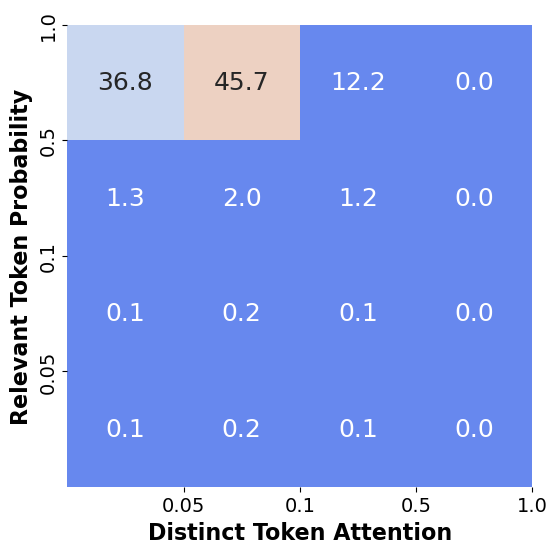

In [22]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


bin_edges = [np.array([0, 0.05, 0.1, 0.5, 1]), np.array([0, 0.05, 0.1, 0.5,  1])]

num = 200

hist,_,_= np.histogram2d( np.array(analysis)[:,-1].astype(float),  np.array(analysis)[:,-2].astype(float), bins=bin_edges)

hist = hist/num
# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:


# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(hist, dtype=object)


for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        annot_array[i, j] = f"{hist[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# # Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.05, 0.1, 0.5, 1])
y_edges = np.array([0, 0.05, 0.1, 0.5, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(hist.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                  annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# # Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# # Save the figure
plt.savefig("faster_qk_10_times_squad_train_l1.pdf", bbox_inches='tight')
plt.show()

In [23]:
# model.eval()

# def generate_answer(context, question):
#     prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')
#     output = model.generate(input_ids, max_new_tokens=10,  eos_token_id=tokenizer.eos_token_id,pad_token_id=tokenizer.eos_token_id)  # Avoid warning if pad token is undefined)
#     answer = tokenizer.decode(output[0], skip_special_tokens=True)
#     return answer.split("Answer:")[-1].strip()

# count = 0 
# # Test on training examples
# for example in squad:
#     print("Q:", example['question'])
#     print("Predicted A:", generate_answer(example['context'], example['question']))
#     print("True A:", example['answers']['text'][0])
#     print("="*60)
#     count +=1
#     if count>50:
#         break


In [16]:
import string
import re
from collections import Counter

def normalize_answer(s):
    """Normalize answer text for comparison"""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.IGNORECASE)
        return re.sub(regex, ' ', text)
    
    def white_space_fix(text):
        return ' '.join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    """Split text into tokens"""
    if not s:
        return []
    return normalize_answer(s).split()

def compute_exact_match(a_gold, a_pred):
    """Compute exact match score"""
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    """Compute F1 score"""
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    
    if not gold_toks and not pred_toks:
        return 1.0
    
    if not gold_toks or not pred_toks:
        return 0.0
    
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    
    if num_same == 0:
        return 0.0
    
    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return f1



def generate_answer(context, question):
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')
    output = model.generate(input_ids, max_new_tokens=10, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.eos_token_id)
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    return answer.split("Answer:")[-1].strip()

In [25]:
# Initialize metrics tracking
count = 0
exact_match_scores = []
f1_scores = []
predictions = []
ground_truths = []

print("Evaluating model on SQuAD examples...")
print("=" * 80)

# Test on training examples
for example in tqdm(squad):
    # Generate prediction
    predicted_answer = generate_answer(example['context'], example['question'])
    true_answers = example['answers']['text']  # List of all valid answers
    
    # Take the best score across all possible answers (SQuAD style)
    em_score = max(compute_exact_match(true_ans, predicted_answer) for true_ans in true_answers)
    f1_score = max(compute_f1(true_ans, predicted_answer) for true_ans in true_answers)
    
    # Store scores
    exact_match_scores.append(em_score)
    f1_scores.append(f1_score)
    predictions.append(predicted_answer)
    ground_truths.append(true_answers[0])  # First answer for display
    
    # Display results
    #print(f"Question {count + 1}:")
    #print(f"Q: {example['question']}")
    #print(f"Predicted A: {predicted_answer}")
    #print(f"True A: {true_answers[0]}")
    #print(f"EM Score: {em_score} | F1 Score: {f1_score:.3f}")
    #print("=" * 60)
    
    # count += 1
    # if count > 5000:
    #     break

# Calculate overall metrics
overall_em = sum(exact_match_scores) / len(exact_match_scores) * 100
overall_f1 = sum(f1_scores) / len(f1_scores) * 100

# Print summary
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)
print(f"Total Questions: {len(exact_match_scores)}")
print(f"Exact Match Score: {overall_em:.2f}%")
print(f"F1 Score: {overall_f1:.2f}%")

# Additional statistics
print(f"\nDetailed Statistics:")
print(f"Questions with EM = 1: {sum(exact_match_scores)} ({sum(exact_match_scores)/len(exact_match_scores)*100:.1f}%)")
print(f"Questions with F1 > 0.5: {sum(1 for f1 in f1_scores if f1 > 0.5)} ({sum(1 for f1 in f1_scores if f1 > 0.5)/len(f1_scores)*100:.1f}%)")
print(f"Average F1 for non-zero scores: {sum(f1 for f1 in f1_scores if f1 > 0) / max(1, sum(1 for f1 in f1_scores if f1 > 0)):.3f}")

# Show some examples of different performance levels
print(f"\n" + "=" * 80)
print("EXAMPLE ANALYSIS")
print("=" * 80)

# Find examples with different performance levels
perfect_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if em == 1]
partial_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if em == 0 and f1 > 0.3]
no_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if f1 == 0]

if perfect_matches:
    print(f"\nPerfect Matches (EM=1): {len(perfect_matches)} examples")
    for i, (idx, pred, true) in enumerate(perfect_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}'")

if partial_matches:
    print(f"\nPartial Matches (EM=0, F1>0.3): {len(partial_matches)} examples")
    for i, (idx, pred, true) in enumerate(partial_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}' | F1: {f1_scores[idx]:.3f}")

if no_matches:
    print(f"\nNo Matches (F1=0): {len(no_matches)} examples")
    for i, (idx, pred, true) in enumerate(no_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}'")

print("=" * 80)

Evaluating model on SQuAD examples...


100%|█████████████████████████████████████| 20000/20000 [31:32<00:00, 10.57it/s]


EVALUATION SUMMARY
Total Questions: 20000
Exact Match Score: 57.14%
F1 Score: 75.62%

Detailed Statistics:
Questions with EM = 1: 11428 (57.1%)
Questions with F1 > 0.5: 15104 (75.5%)
Average F1 for non-zero scores: 0.853

EXAMPLE ANALYSIS

Perfect Matches (EM=1): 11428 examples
  1. Predicted: 'Saint Bernadette Soubirous' | True: 'Saint Bernadette Soubirous'
  2. Predicted: 'the Main Building' | True: 'the Main Building'
  3. Predicted: 'September 1876' | True: 'September 1876'

Partial Matches (EM=0, F1>0.3): 5721 examples
  1. Predicted: 'a copper statue of Christ with arms raised with the' | True: 'a copper statue of Christ' | F1: 0.667
  2. Predicted: 'a Marian place of prayer and reflection. It is' | True: 'a Marian place of prayer and reflection' | F1: 0.857
  3. Predicted: 'twice a year' | True: 'twice' | F1: 0.667

No Matches (F1=0): 2277 examples
  1. Predicted: '' | True: 'a golden statue of the Virgin Mary'
  2. Predicted: 'the' | True: 'the Science Department'
  3. Predict

In [26]:
# Create a directory to save
save_path = "./faster_saved_1"

# Save model
model.save_pretrained(save_path)

# Save tokenizer
tokenizer.save_pretrained(save_path)

('./faster_saved_1/tokenizer_config.json',
 './faster_saved_1/special_tokens_map.json',
 './faster_saved_1/vocab.json',
 './faster_saved_1/merges.txt',
 './faster_saved_1/added_tokens.json',
 './faster_saved_1/tokenizer.json')

In [17]:
from transformers import GPT2TokenizerFast
# Path to saved model
save_path = "./faster_saved_1"

# Load config
config = GPT2Config.from_pretrained(save_path)

# Load tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained(save_path)

# Load custom model
model = CustomGPT2LMHeadModel.from_pretrained(save_path, config=config).to(device)

In [18]:
from datasets import load_dataset
from tqdm import tqdm as tqdm


squad_validation = load_dataset("squad", split="train[20000:25000]")  # Small subset for testing



# formatted_validation = squad_validation.map(format_qa) # format_qa is a function


# tokenized_validation = formatted_validation.map(tokenize) # tokenize is a function



# qa_dataset_validation = QADataset(tokenized_validation)

# # DataLoader with default collate_fn
# dataloader_validation = DataLoader(qa_dataset_validation, batch_size=8, shuffle=True)

In [26]:
# Main evaluation loop
count = 0
model.eval()
analysis_validation = []
for example in tqdm(squad_validation):
    context = example["context"]
    question = example["question"]
    answer_text = example["answers"]["text"][0]
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"

    # Encode prompt with offsets
    encodings = tokenizer(prompt, return_offsets_mapping=True, add_special_tokens=False, return_tensors="pt")
    input_ids = encodings["input_ids"].to(device)
    offsets = encodings["offset_mapping"][0].tolist()  # list of (start, end)

    # Locate where context starts in prompt (to offset answer span properly)
    context_start_in_prompt = prompt.find(context)
    answer_start_char = example["answers"]["answer_start"][0] + context_start_in_prompt
    answer_end_char = answer_start_char + len(answer_text)

    # Map character span of answer to token indices in the prompt
    token_indices = [
        i for i, (start, end) in enumerate(offsets)
        if start < answer_end_char and end > answer_start_char
    ]

    # Encode ground-truth answer tokens WITH leading space because generated tokens usually include it
    answer_ids = tokenizer.encode(" " + answer_text, add_special_tokens=False)
    answer_ids = torch.tensor(answer_ids).to(device)

    # Generate predicted answer + track true token probabilities
    output, attns, true_token_probs = generate_outputs(model, tokenizer, input_ids, answer_ids, device)

    # Normalize answers for fair comparison
    norm_true = normalize_text(answer_text)
    norm_pred = normalize_text(output)

    # Average true token probability over all steps
    avg_true_token_prob = sum(true_token_probs) / len(true_token_probs)

    # Compute average attention score over heads and steps for true token indices
    total_attention = 0.0
    for step_attn in attns:
        last_layer_attn = step_attn[1][0]  # last layer, batch 0: (num_heads, seq_len)
        step_total = 0.0
        for h in range(last_layer_attn.shape[0]):
            head_attn = last_layer_attn[h]
            step_total += sum(head_attn[j] for j in token_indices if j < head_attn.shape[0])
        avg_step_attn = step_total / last_layer_attn.shape[0]  # average over heads
        total_attention += avg_step_attn
    true_token_attention_score = total_attention / len(attns)  # average over steps

    # Print results
    #print("=" * 60)
    #print(f"Example #{count + 1}")
    #print("True Answer     :", answer_text)
    #print("Predicted Answer:", output)
    #print("Normalized True :", norm_true)
    #print("Normalized Pred :", norm_pred)
    #print("Avg True Token Prob: {:.6f}".format(avg_true_token_prob))
    #print("True Token Attention Score: {:.6f}".format(true_token_attention_score.item()))

    analysis_validation.append([norm_true,norm_pred,avg_true_token_prob,true_token_attention_score.item()])

    # count += 1
    # if count >= 200:
    #     break

100%|███████████████████████████████████████| 5000/5000 [04:36<00:00, 18.05it/s]


In [27]:
analysis_validation

[['taongi', 'san bartol', 0.0008148198340971717, 0.015021972358226776],
 ['álvaro de saavedra cerón',
  'álvaro de saavedra cerón',
  0.8262106943875551,
  0.16219961643218994],
 ['the maluku islands',
  'maluku islands',
  0.07137719295750422,
  0.09300446510314941],
 ['los pintados', 'los pintados', 0.9775886088609695, 0.08572913706302643],
 ['los jardines', 'los pintados', 0.28674430163350056, 0.025672970339655876],
 ['enewetak or bikini atoll',
  'enewetak or bikini atoll',
  0.8905504941940308,
  0.1292472928762436],
 ['álvaro de saavedra cerón',
  'álvaro de saavedra cerón',
  0.8933156317099928,
  0.16157497465610504],
 ['the maluku islands',
  'the pacific islands',
  0.2135789506349471,
  0.03604326397180557],
 ['los pintados', 'los pintados', 0.9680976122617722, 0.08604539930820465],
 ['los jardines', 'los jardines', 0.979377880692482, 0.07243435084819794],
 ['eight days', 'eight days', 0.9888300895690918, 0.05582287907600403],
 ['los barbudos', 'los barbés', 0.63335356752698

In [28]:
import json

# Save to file
with open("diff_validation_qa_eval_results_validation_l1.json", "w") as f:
    json.dump(analysis_validation, f, indent=2)

In [29]:
tt = np.array(analysis_validation)[:,-1].astype(float)
sum(tt<=0.05)+sum(tt>0.05)

5000

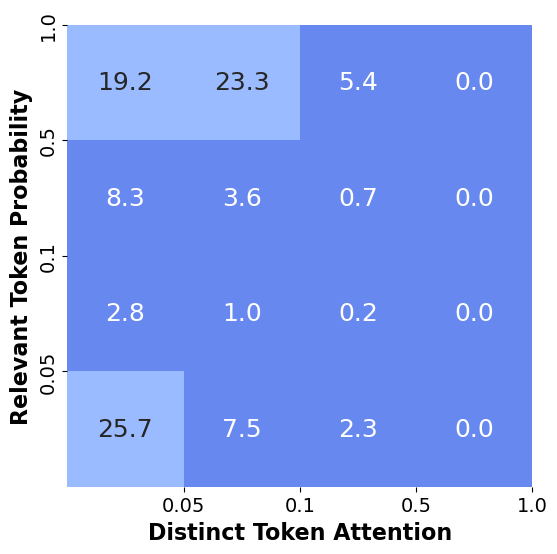

In [30]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


bin_edges = [np.array([0, 0.05, 0.1, 0.5, 1]), np.array([0, 0.05, 0.1, 0.5,  1])]

num = 50

hist,_,_= np.histogram2d( np.array(analysis_validation)[:,-1].astype(float),  np.array(analysis_validation)[:,-2].astype(float), bins=bin_edges)

hist = hist/num
# Assuming `mean_hist_norm` and `var_hist_norm` are your 2D arrays of the same shape
# If you prefer to show std instead of variance in the annotation, convert variance to std:


# Create annotation labels with both mean and std (formatted as strings)
annot_array = np.empty_like(hist, dtype=object)


for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        annot_array[i, j] = f"{hist[i, j]:.1f}"#\n(±{std_hist_norm[i, j]:.1f})"  # mean ± std

# # Define tick positions for edges of bins (for correct labeling)
x_edges = np.array([0, 0.05, 0.1, 0.5, 1])
y_edges = np.array([0, 0.05, 0.1, 0.5, 1])
xtick_positions = np.arange(len(x_edges) - 1) + 1.0  # Right edges
ytick_positions = np.arange(len(y_edges) - 1) + 1.0  # Top edges

# Plot heatmap for mean values (color intensity)
plt.figure(figsize=(6, 6))
ax = sns.heatmap(hist.T, annot=annot_array.T, cmap=sns.color_palette("coolwarm"), 
                  annot_kws={"size":18}, cbar=False, vmin=5, vmax=70,fmt="")

# Adjust tick positions for x and y axes (move them to the edges)
ax.set_xticks(xtick_positions)
ax.set_yticks(ytick_positions)

# Set the labels for ticks (x and y edges)
ax.set_xticklabels(x_edges[1:])
ax.set_yticklabels(y_edges[1:])

# # Make the tick labels bold
ax.tick_params(axis='x', labelsize=14)  # Bold x-axis labels
ax.tick_params(axis='y', labelsize=14)  # Bold y-axis labels


# Invert y-axis to align with typical heatmap style
ax.invert_yaxis()

# Labels and title
plt.xlabel(r"Distinct Token Attention", fontweight="bold", fontsize=16)
plt.ylabel(r"Relevant Token Probability", fontweight="bold", fontsize=16)
#plt.title("Mean (±Std Dev) Heatmap")

# # Save the figure
plt.savefig("faster_qk_10_times_squad_validation_l1.pdf", bbox_inches='tight')
plt.show()

In [19]:
# Initialize metrics tracking
count = 0
exact_match_scores = []
f1_scores = []
predictions = []
ground_truths = []

print("Evaluating model on SQuAD examples...")
print("=" * 80)

# Test on training examples
for example in tqdm(squad_validation):
    # Generate prediction
    predicted_answer = generate_answer(example['context'], example['question'])
    true_answers = example['answers']['text']  # List of all valid answers
    
    # Take the best score across all possible answers (SQuAD style)
    em_score = max(compute_exact_match(true_ans, predicted_answer) for true_ans in true_answers)
    f1_score = max(compute_f1(true_ans, predicted_answer) for true_ans in true_answers)
    
    # Store scores
    exact_match_scores.append(em_score)
    f1_scores.append(f1_score)
    predictions.append(predicted_answer)
    ground_truths.append(true_answers[0])  # First answer for display
    
    # Display results
    #print(f"Question {count + 1}:")
    #print(f"Q: {example['question']}")
    #print(f"Predicted A: {predicted_answer}")
    #print(f"True A: {true_answers[0]}")
    #print(f"EM Score: {em_score} | F1 Score: {f1_score:.3f}")
    #print("=" * 60)
    
    # count += 1
    # if count > 5000:
    #     break

# Calculate overall metrics
overall_em = sum(exact_match_scores) / len(exact_match_scores) * 100
overall_f1 = sum(f1_scores) / len(f1_scores) * 100

# Print summary
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)
print(f"Total Questions: {len(exact_match_scores)}")
print(f"Exact Match Score: {overall_em:.2f}%")
print(f"F1 Score: {overall_f1:.2f}%")

# Additional statistics
print(f"\nDetailed Statistics:")
print(f"Questions with EM = 1: {sum(exact_match_scores)} ({sum(exact_match_scores)/len(exact_match_scores)*100:.1f}%)")
print(f"Questions with F1 > 0.5: {sum(1 for f1 in f1_scores if f1 > 0.5)} ({sum(1 for f1 in f1_scores if f1 > 0.5)/len(f1_scores)*100:.1f}%)")
print(f"Average F1 for non-zero scores: {sum(f1 for f1 in f1_scores if f1 > 0) / max(1, sum(1 for f1 in f1_scores if f1 > 0)):.3f}")

# Show some examples of different performance levels
print(f"\n" + "=" * 80)
print("EXAMPLE ANALYSIS")
print("=" * 80)

# Find examples with different performance levels
perfect_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if em == 1]
partial_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if em == 0 and f1 > 0.3]
no_matches = [(i, predictions[i], ground_truths[i]) for i, (em, f1) in enumerate(zip(exact_match_scores, f1_scores)) if f1 == 0]

if perfect_matches:
    print(f"\nPerfect Matches (EM=1): {len(perfect_matches)} examples")
    for i, (idx, pred, true) in enumerate(perfect_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}'")

if partial_matches:
    print(f"\nPartial Matches (EM=0, F1>0.3): {len(partial_matches)} examples")
    for i, (idx, pred, true) in enumerate(partial_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}' | F1: {f1_scores[idx]:.3f}")

if no_matches:
    print(f"\nNo Matches (F1=0): {len(no_matches)} examples")
    for i, (idx, pred, true) in enumerate(no_matches[:3]):
        print(f"  {i+1}. Predicted: '{pred}' | True: '{true}'")

print("=" * 80)

Evaluating model on SQuAD examples...


100%|███████████████████████████████████████| 5000/5000 [08:10<00:00, 10.19it/s]


EVALUATION SUMMARY
Total Questions: 5000
Exact Match Score: 28.96%
F1 Score: 45.99%

Detailed Statistics:
Questions with EM = 1: 1448 (29.0%)
Questions with F1 > 0.5: 2201 (44.0%)
Average F1 for non-zero scores: 0.750

EXAMPLE ANALYSIS

Perfect Matches (EM=1): 1448 examples
  1. Predicted: 'Álvaro de Saavedra cerón' | True: 'Álvaro de Saavedra Cerón'
  2. Predicted: 'the Maluku Islands' | True: 'the Maluku Islands'
  3. Predicted: 'Enewetak or Bikini Atoll' | True: 'Enewetak or Bikini Atoll'

Partial Matches (EM=0, F1>0.3): 1337 examples
  1. Predicted: 'Los J' | True: 'Los Pintados' | F1: 0.500
  2. Predicted: 'Los J' | True: 'Los Jardines' | F1: 0.500
  3. Predicted: 'Los Jard' | True: 'Los Jardines' | F1: 0.500

No Matches (F1=0): 1935 examples
  1. Predicted: 'San Bartolome' | True: 'Taongi'
  2. Predicted: 'Los Barbés' | True: 'Mejit'
  3. Predicted: '"' | True: 'Corrales'


### Custom Model and GPT Pretrained Model Weight and Output Comparison

In [ ]:
# import torch
# import torch.nn as nn
# from transformers import GPT2LMHeadModel, GPT2Config
# from transformers.models.gpt2.modeling_gpt2 import GPT2Block, GPT2Model, GPT2PreTrainedModel
# from transformers.modeling_utils import Conv1D

# # --------- Custom Attention Module using Conv1D ----------
# class CustomGPT2Attention(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.embed_dim = config.hidden_size
#         self.num_heads = config.num_attention_heads
#         self.head_dim = self.embed_dim // self.num_heads
#         assert self.head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

#         self.q_proj = Conv1D(self.embed_dim, self.embed_dim)
#         self.k_proj = Conv1D(self.embed_dim, self.embed_dim)
#         self.v_proj = Conv1D(self.embed_dim, self.embed_dim)
#         self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

#         self.attn_dropout = nn.Dropout(config.attn_pdrop)
#         self.resid_dropout = nn.Dropout(config.resid_pdrop)
#         self.scale = self.head_dim ** -0.5
        
#         # Register causal mask buffer (same as original GPT2)
#         max_positions = config.max_position_embeddings
#         self.register_buffer(
#             "bias",
#             torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
#                 1, 1, max_positions, max_positions
#             ),
#         )
#         self.register_buffer("masked_bias", torch.tensor(-1e4))

#     def _split_heads(self, x):
#         batch_size, seq_len, embed_dim = x.size()
#         # embed_dim should equal num_heads * head_dim
#         assert embed_dim == self.num_heads * self.head_dim, f"Embed dim {embed_dim} != num_heads * head_dim {self.num_heads * self.head_dim}"
        
#         # reshape to (batch_size, seq_len, num_heads, head_dim)
#         x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
#         # permute to (batch_size, num_heads, seq_len, head_dim)
#         return x.permute(0, 2, 1, 3)

#     def _merge_heads(self, x):
#         x = x.permute(0, 2, 1, 3).contiguous()
#         new_shape = x.size()[:-2] + (self.embed_dim,)
#         return x.view(*new_shape)

#     def forward(self, hidden_states, layer_past=None, attention_mask=None,
#                 head_mask=None, use_cache=False, output_attentions=False):
    
#         # Project to Q, K, V
#         query = self.q_proj(hidden_states)
#         key = self.k_proj(hidden_states)
#         value = self.v_proj(hidden_states)

#         # Split heads
#         query = self._split_heads(query)
#         key = self._split_heads(key)
#         value = self._split_heads(value)

#         # Handle past keys/values for generation
#         if layer_past is not None:
#             past_key, past_value = layer_past
#             key = torch.cat((past_key, key), dim=-2)
#             value = torch.cat((past_value, value), dim=-2)

#         if use_cache:
#             present = (key, value)
#         else:
#             present = None

#         # Compute attention weights
#         attn_weights = torch.matmul(query, key.transpose(-1, -2))
#         attn_weights = attn_weights * self.scale

#         # Apply causal mask
#         query_length, key_length = query.size(-2), key.size(-2)
#         causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
#         mask_value = torch.finfo(attn_weights.dtype).min
#         mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
#         attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

#         # Apply attention mask if provided
#         if attention_mask is not None:
#             attn_weights = attn_weights + attention_mask

#         # Softmax
#         attn_weights = nn.functional.softmax(attn_weights, dim=-1)
#         attn_weights = attn_weights.type(value.dtype)
#         attn_weights = self.attn_dropout(attn_weights)

#         # Apply head mask if provided
#         if head_mask is not None:
#             attn_weights = attn_weights * head_mask

#         # Apply attention to values
#         attn_output = torch.matmul(attn_weights, value)
#         attn_output = self._merge_heads(attn_output)

#         # Final projection
#         attn_output = self.c_proj(attn_output)
#         attn_output = self.resid_dropout(attn_output)

#         outputs = (attn_output, present)
#         if output_attentions:
#             outputs += (attn_weights,)

#         return outputs
# # --------- Custom GPT2 Block ----------
# class CustomGPT2Block(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
#         self.attn = CustomGPT2Attention(config)
#         self.ln_2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
#         self.mlp = GPT2Block(config).mlp

#     def forward(
#         self,
#         hidden_states,
#         layer_past=None,
#         attention_mask=None,
#         head_mask=None,
#         encoder_hidden_states=None,
#         encoder_attention_mask=None,
#         use_cache=False,
#         output_attentions=False,
#     ):
#         residual = hidden_states
#         hidden_states = self.ln_1(hidden_states)

#         attn_outputs = self.attn(
#             hidden_states,
#             layer_past=layer_past,
#             attention_mask=attention_mask,
#             head_mask=head_mask,
#             use_cache=use_cache,
#             output_attentions=output_attentions,
#         )

#         attn_output = attn_outputs[0]
#         outputs = attn_outputs[1:]

#         hidden_states = residual + attn_output

#         residual = hidden_states
#         hidden_states = self.ln_2(hidden_states)
#         feed_forward_hidden_states = self.mlp(hidden_states)
#         hidden_states = residual + feed_forward_hidden_states

#         return (hidden_states,) + outputs

# # --------- Custom GPT2 Model ----------
# class CustomGPT2Model(GPT2Model):
#     def __init__(self, config):
#         super().__init__(config)
#         self.h = nn.ModuleList([CustomGPT2Block(config) for _ in range(config.num_hidden_layers)])

# # --------- Custom GPT2 LM Model ----------
# class CustomGPT2LMHeadModel(GPT2PreTrainedModel):
#     def __init__(self, config):
#         super().__init__(config)
#         self.transformer = CustomGPT2Model(config)
#         self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
#         self.init_weights()

#     def forward(self, input_ids=None, **kwargs):
#         transformer_outputs = self.transformer(input_ids=input_ids, **kwargs)
#         hidden_states = transformer_outputs[0]
#         lm_logits = self.lm_head(hidden_states)
#         return lm_logits

# # --------- Copy Weights from Original GPT2 Model ----------
# def copy_weights(original_model, custom_model):
#     orig_state_dict = original_model.state_dict()
#     custom_state_dict = custom_model.state_dict()

#     for name, param in orig_state_dict.items():
#         if "attn.c_attn.weight" in name:
#             layer_num = int(name.split('.')[2])
#             prefix = f'transformer.h.{layer_num}.attn.'
            
#             # Original c_attn weight shape: (embed_dim, 3 * embed_dim)
#             # Need to split along dim=1 (the 3 * embed_dim dimension)
#             embed_dim = param.shape[0]
#             q_weight, k_weight, v_weight = torch.split(param, embed_dim, dim=1)
            
#             # Conv1D weight shape is (input_dim, output_dim), no transpose needed
#             custom_state_dict[f'{prefix}q_proj.weight'].copy_(q_weight)
#             custom_state_dict[f'{prefix}k_proj.weight'].copy_(k_weight)  
#             custom_state_dict[f'{prefix}v_proj.weight'].copy_(v_weight)

#         elif "attn.c_attn.bias" in name:
#             layer_num = int(name.split('.')[2])
#             prefix = f'transformer.h.{layer_num}.attn.'
#             hidden_size = param.shape[0] // 3

#             q_bias, k_bias, v_bias = torch.split(param, hidden_size)
#             custom_state_dict[f'{prefix}q_proj.bias'].copy_(q_bias)
#             custom_state_dict[f'{prefix}k_proj.bias'].copy_(k_bias)
#             custom_state_dict[f'{prefix}v_proj.bias'].copy_(v_bias)

#         elif "attn.c_proj.weight" in name:
#             # Copy c_proj weights directly
#             layer_num = int(name.split('.')[2])
#             prefix = f'transformer.h.{layer_num}.attn.'
#             custom_state_dict[f'{prefix}c_proj.weight'].copy_(param)
            
#         else:
#             if name in custom_state_dict:
#                 custom_state_dict[name].copy_(param)

#     custom_model.load_state_dict(custom_state_dict)

# # --------- Parameter Comparison ----------
# def compare_model_parameters(original_model, custom_model):
#     orig_params = dict(original_model.named_parameters())
#     cust_params = dict(custom_model.named_parameters())

#     print("--- Comparing Non-Split Parameters ---")
#     for name, orig_param in orig_params.items():
#         if "attn.c_attn" in name or "attn.c_proj.weight" in name:
#             continue
#         if name not in cust_params:
#             print(f"Parameter {name} missing in custom model")
#             continue
#         cust_param = cust_params[name]
#         if torch.allclose(orig_param, cust_param, atol=1e-6):
#             c = 1 #print(f"Parameter {name} matches.")
#         else:
#             print(f"Parameter {name} differs!")

#     print("\n--- Comparing Split QKV Parameters ---")
#     for i in range(original_model.config.num_hidden_layers):
#         prefix = f'transformer.h.{i}.'
#         orig_w = orig_params[f'{prefix}attn.c_attn.weight']
#         orig_b = orig_params[f'{prefix}attn.c_attn.bias']
#         orig_proj_w = orig_params[f'{prefix}attn.c_proj.weight']
        
#         hidden_size = orig_w.shape[0]

#         # Split the original concatenated weights
#         orig_qw, orig_kw, orig_vw = torch.split(orig_w, hidden_size, dim=1)
#         orig_qb, orig_kb, orig_vb = torch.split(orig_b, hidden_size)

#         # Get custom model parameters
#         cust_qw = cust_params[f'{prefix}attn.q_proj.weight']
#         cust_qb = cust_params[f'{prefix}attn.q_proj.bias']
#         cust_kw = cust_params[f'{prefix}attn.k_proj.weight']
#         cust_kb = cust_params[f'{prefix}attn.k_proj.bias']
#         cust_vw = cust_params[f'{prefix}attn.v_proj.weight']
#         cust_vb = cust_params[f'{prefix}attn.v_proj.bias']
#         cust_proj_w = cust_params[f'{prefix}attn.c_proj.weight']

#         # Compare weights (no transpose needed for Conv1D)
#         if torch.allclose(orig_qw, cust_qw, atol=1e-6): c = 1#print(f"Layer {i} Q weight matches.")
#         else: print(f"Layer {i} Q weight differs!")
        
#         if torch.allclose(orig_kw, cust_kw, atol=1e-6): c =1 #print(f"Layer {i} K weight matches.")
#         else: print(f"Layer {i} K weight differs!")
        
#         if torch.allclose(orig_vw, cust_vw, atol=1e-6): c =1 #print(f"Layer {i} V weight matches.")
#         else: print(f"Layer {i} V weight differs!")
        
#         if torch.allclose(orig_proj_w, cust_proj_w, atol=1e-6): c= 1#print(f"Layer {i} c_proj weight matches.")
#         else: print(f"Layer {i} c_proj weight differs!")

#         # Compare biases (no transpose needed)
#         if torch.allclose(orig_qb, cust_qb, atol=1e-6): c= 1#print(f"Layer {i} Q bias matches.")
#         else: print(f"Layer {i} Q bias differs!")
        
#         if torch.allclose(orig_kb, cust_kb, atol=1e-6): c =1 #print(f"Layer {i} K bias matches.")
#         else: print(f"Layer {i} K bias differs!")
        
#         if torch.allclose(orig_vb, cust_vb, atol=1e-6): c = 1#print(f"Layer {i} V bias matches.")
#         else: print(f"Layer {i} V bias differs!")

# # --------- Output Comparison ----------
# def check_outputs_identical(original_model, custom_model):
#     original_model.eval()
#     custom_model.eval()

#     batch_size = 2
#     seq_len = 16
#     vocab_size = original_model.config.vocab_size
#     input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

#     with torch.no_grad():
#         orig_logits = original_model(input_ids).logits
#         cust_logits = custom_model(input_ids)

#     max_diff = torch.max(torch.abs(orig_logits - cust_logits)).item()
#     print(f"\n--- Comparing Model Outputs ---")
#     print(f"Max absolute difference between outputs: {max_diff:.10f}")# Additional debugging steps to minimize differences

# def debug_attention_step_by_step(original_model, custom_model, input_ids):
#     """Compare intermediate outputs in the first attention layer"""
#     original_model.eval()
#     custom_model.eval()
    
#     with torch.no_grad():
#         # Get embeddings (should be identical)
#         orig_embeds = original_model.transformer.wte(input_ids) + original_model.transformer.wpe(torch.arange(input_ids.size(1), device=input_ids.device))
#         cust_embeds = custom_model.transformer.wte(input_ids) + custom_model.transformer.wpe(torch.arange(input_ids.size(1), device=input_ids.device))
        
#         print("Embedding difference:", torch.max(torch.abs(orig_embeds - cust_embeds)).item())
        
#         # First layer norm
#         orig_ln1 = original_model.transformer.h[0].ln_1(orig_embeds)
#         cust_ln1 = custom_model.transformer.h[0].ln_1(cust_embeds)
        
#         print("First LayerNorm difference:", torch.max(torch.abs(orig_ln1 - cust_ln1)).item())
        
#         # QKV projections
#         orig_qkv = original_model.transformer.h[0].attn.c_attn(orig_ln1)
#         orig_q, orig_k, orig_v = orig_qkv.split(original_model.config.hidden_size, dim=2)
        
#         cust_q = custom_model.transformer.h[0].attn.q_proj(cust_ln1)
#         cust_k = custom_model.transformer.h[0].attn.k_proj(cust_ln1)
#         cust_v = custom_model.transformer.h[0].attn.v_proj(cust_ln1)
        
#         print("Q projection difference:", torch.max(torch.abs(orig_q - cust_q)).item())
#         print("K projection difference:", torch.max(torch.abs(orig_k - cust_k)).item())
#         print("V projection difference:", torch.max(torch.abs(orig_v - cust_v)).item())

# def ensure_identical_initialization():
#     """Ensure both models have identical random initialization states"""
#     torch.manual_seed(42)
#     torch.cuda.manual_seed_all(42)
#     # Set deterministic behavior
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Alternative: Use double precision for comparison
# def check_outputs_double_precision(original_model, custom_model):
#     """Check outputs using double precision for more accurate comparison"""
#     original_model.eval()
#     custom_model.eval()
    
#     # Convert to double precision
#     original_model = original_model.double()
#     custom_model = custom_model.double()
    
#     batch_size = 2
#     seq_len = 16
#     vocab_size = original_model.config.vocab_size
#     input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

#     with torch.no_grad():
#         orig_logits = original_model(input_ids).logits
#         cust_logits = custom_model(input_ids)

#     max_diff = torch.max(torch.abs(orig_logits - cust_logits)).item()
#     print(f"Double precision max difference: {max_diff:.15f}")
#     return max_diff
#     if max_diff < 1e-4:
#         print("Success! Outputs match within tolerance.")
#     else:
#         print("Failure! Outputs still differ.")


# config = GPT2Config.from_pretrained("gpt2")

# print("Loading original GPT-2 model...")
# original_model = GPT2LMHeadModel.from_pretrained("gpt2")

# print("Creating custom GPT-2 model with split Q,K,V...")
# custom_model = CustomGPT2LMHeadModel(config)

# print("Copying weights...")
# copy_weights(original_model, custom_model)

# print("\nComparing parameters...")
# compare_model_parameters(original_model, custom_model)

# check_outputs_identical(original_model, custom_model)


In [ ]:
# # Additional debugging steps to minimize differences

# def debug_attention_step_by_step(original_model, custom_model, input_ids):
#     """Compare intermediate outputs in the first attention layer"""
#     original_model.eval()
#     custom_model.eval()
    
#     with torch.no_grad():
#         # Get embeddings (should be identical)
#         orig_embeds = original_model.transformer.wte(input_ids) + original_model.transformer.wpe(torch.arange(input_ids.size(1), device=input_ids.device))
#         cust_embeds = custom_model.transformer.wte(input_ids) + custom_model.transformer.wpe(torch.arange(input_ids.size(1), device=input_ids.device))
        
#         print("Embedding difference:", torch.max(torch.abs(orig_embeds - cust_embeds)).item())
        
#         # First layer norm
#         orig_ln1 = original_model.transformer.h[0].ln_1(orig_embeds)
#         cust_ln1 = custom_model.transformer.h[0].ln_1(cust_embeds)
        
#         print("First LayerNorm difference:", torch.max(torch.abs(orig_ln1 - cust_ln1)).item())
        
#         # QKV projections
#         orig_qkv = original_model.transformer.h[0].attn.c_attn(orig_ln1)
#         orig_q, orig_k, orig_v = orig_qkv.split(original_model.config.hidden_size, dim=2)
        
#         cust_q = custom_model.transformer.h[0].attn.q_proj(cust_ln1)
#         cust_k = custom_model.transformer.h[0].attn.k_proj(cust_ln1)
#         cust_v = custom_model.transformer.h[0].attn.v_proj(cust_ln1)
        
#         print("Q projection difference:", torch.max(torch.abs(orig_q - cust_q)).item())
#         print("K projection difference:", torch.max(torch.abs(orig_k - cust_k)).item())
#         print("V projection difference:", torch.max(torch.abs(orig_v - cust_v)).item())

# def ensure_identical_initialization():
#     """Ensure both models have identical random initialization states"""
#     torch.manual_seed(42)
#     torch.cuda.manual_seed_all(42)
#     # Set deterministic behavior
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Alternative: Use double precision for comparison
# def check_outputs_double_precision(original_model, custom_model):
#     """Check outputs using double precision for more accurate comparison"""
#     original_model.eval()
#     custom_model.eval()
    
#     # Convert to double precision
#     original_model = original_model.double()
#     custom_model = custom_model.double()
    
#     batch_size = 2
#     seq_len = 16
#     vocab_size = original_model.config.vocab_size
#     input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

#     with torch.no_grad():
#         orig_logits = original_model(input_ids).logits
#         cust_logits = custom_model(input_ids)

#     max_diff = torch.max(torch.abs(orig_logits - cust_logits)).item()
#     print(f"Double precision max difference: {max_diff:.15f}")
    
#     # Convert back to float
#     original_model = original_model.float()
#     custom_model = custom_model.float()
    
#     return max_diff

In [ ]:
# vocab_size = original_model.config.vocab_size
# input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

# debug_attention_step_by_step(original_model, custom_model, input_ids)

In [ ]:
# check_outputs_double_precision(original_model, custom_model)